<a href="https://colab.research.google.com/github/NerconX/finetuning-senior-project-/blob/main/Senior_Project_Example_1_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q bitsandbytes datasets accelerate
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git@main

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# Select CUDA device index
import os
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_name = "google/flan-t5-large"

model = AutoModelForSeq2SeqLM.from_pretrained(model_name, load_in_8bit=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [ ]:
from peft import prepare_model_for_int8_training

model = prepare_model_for_int8_training(model)

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:136: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


In [ ]:
from peft import LoraConfig, get_peft_model, TaskType


def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )


lora_config = LoraConfig(
    r=16, lora_alpha=32, target_modules=["q", "v"], lora_dropout=0.05, bias="none", task_type="SEQ_2_SEQ_LM"
)


model = get_peft_model(model, lora_config)
print_trainable_parameters(model)

trainable params: 4718592 || all params: 787868672 || trainable%: 0.5989059049678777


In [ ]:
# loading dataset
dataset = load_dataset("financial_phrasebank", "sentences_allagree")
dataset = dataset["train"].train_test_split(test_size=0.1)
dataset["validation"] = dataset["test"]
del dataset["test"]

classes = dataset["train"].features["label"].names
dataset = dataset.map(
    lambda x: {"text_label": [classes[label] for label in x["label"]]},
    batched=True,
    num_proc=1,
)

Generating train split:   0%|          | 0/2264 [00:00<?, ? examples/s]

Map:   0%|          | 0/2037 [00:00<?, ? examples/s]

Map:   0%|          | 0/227 [00:00<?, ? examples/s]

In [ ]:
# data preprocessing
text_column = "sentence"
label_column = "text_label"
max_length = 128


def preprocess_function(examples):
    inputs = examples[text_column]
    targets = examples[label_column]
    model_inputs = tokenizer(inputs, max_length=max_length, padding="max_length", truncation=True, return_tensors="pt")
    labels = tokenizer(targets, max_length=3, padding="max_length", truncation=True, return_tensors="pt")
    labels = labels["input_ids"]
    labels[labels == tokenizer.pad_token_id] = -100
    model_inputs["labels"] = labels
    return model_inputs


processed_datasets = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=dataset["train"].column_names,
    load_from_cache_file=False,
    desc="Running tokenizer on dataset",
)

train_dataset = processed_datasets["train"]
eval_dataset = processed_datasets["validation"]

Running tokenizer on dataset:   0%|          | 0/2037 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/227 [00:00<?, ? examples/s]

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    "temp",
    evaluation_strategy="epoch",
    learning_rate=1e-3,
    gradient_accumulation_steps=1,
    auto_find_batch_size=True,
    num_train_epochs=3,
    #per_device_train_batch_size=1,
    #per_device_eval_batch_size=1,
    #warmup_steps=100,
    #save_steps=100,
    save_total_limit=8,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
   eval_dataset=eval_dataset,
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch,Training Loss,Validation Loss
1,No log,0.032043
2,0.158600,0.027087
3,0.158600,0.026388


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


TrainOutput(global_step=765, training_loss=0.10887392019134721, metrics={'train_runtime': 870.7033, 'train_samples_per_second': 7.018, 'train_steps_per_second': 0.879, 'total_flos': 3543254759374848.0, 'train_loss': 0.10887392019134721, 'epoch': 3.0})

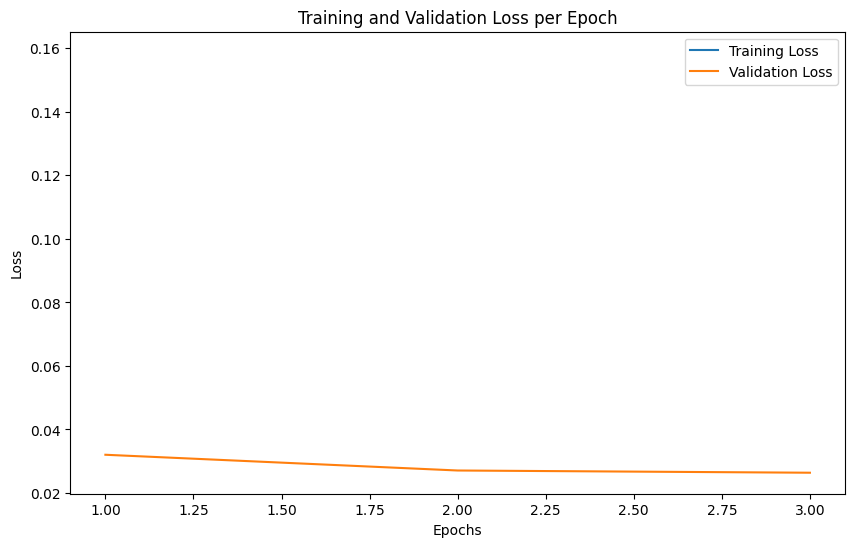

In [ ]:
import matplotlib.pyplot as plt

# Extracting loss values for plotting
training_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
validation_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# Number of epochs should match the longer of the two lists
num_epochs = max(len(training_loss), len(validation_loss))
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))

# Plot Training Loss if available
if training_loss:
    plt.plot(epochs[:len(training_loss)], training_loss, label='Training Loss')

# Plot Validation Loss if available
if validation_loss:
    plt.plot(epochs[:len(validation_loss)], validation_loss, label='Validation Loss')

plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
model.eval()
input_text = "In January-September 2009 , the Group 's net interest income increased to EUR 112.4 mn from EUR 74.3 mn in January-September 2008 ."
inputs = tokenizer(input_text, return_tensors="pt")

outputs = model.generate(input_ids=inputs["input_ids"], max_new_tokens=10)

print("input sentence: ", input_text)
print(" output prediction: ", tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1517: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1635: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


input sentence:  In January-September 2009 , the Group 's net interest income increased to EUR 112.4 mn from EUR 74.3 mn in January-September 2008 .
 output prediction:  ['positive']
